# Create ocean tritium deposition field
Created by Ivan Lima on Thu, 05 Oct 2017 11:17:12 -0400

**Based on Michaela's fits to the GNIP data**

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import griddata, bisplev, bisplrep, splrep, splev
#from scipy.signal import savgol_filter
from datetime import datetime
from cesm_utils import dpm
print('Last updated on {}'.format(datetime.now().ctime()))

Last updated on Wed Mar  6 11:06:30 2019


## Read GNIP blended fits

In [2]:
file = '/home/ivan/Projects/Tritium-3H/Michaela/curve_fitting/precip/coast_output.pkl'
fp    = open(file,'rb')
pkl   = pickle.load(fp,encoding='latin1')
skeys = np.array([k for k in pkl.keys()])
nkeys = np.array([np.int(np.float(k)) for k in skeys])
for case in ['fit']:
    print(40*'-')
    for k in skeys[np.argsort(nkeys)]:
        print(case, k, pkl[k][case][0].shape,pkl[k][case][1].shape, pkl[k][case][0].min(), pkl[k][case][0].max())

----------------------------------------
fit -70.0 (365,) (365,) 1950.0 2010.0
fit -60.0 (423,) (423,) 1950.0 2009.9999999999854
fit -50.0 (318,) (318,) 1950.0 2011.0
fit -40.0 (318,) (318,) 1950.0 2011.0
fit -30.0 (342,) (342,) 1950.0 2011.0
fit -20.0 (443,) (443,) 1950.0 2009.9999999999818
fit -10.0 (337,) (337,) 1950.0 2011.0
fit 0.0 (412,) (412,) 1950.0 2009.999999999989
fit 10.0 (339,) (339,) 1950.0 2010.0
fit 20.0 (340,) (340,) 1950.0 2011.0
fit 30.0 (342,) (342,) 1950.0 2011.0
fit 40.0 (343,) (343,) 1950.0 2011.0
fit 50.0 (342,) (342,) 1950.0 2011.0
fit 60.0 (396,) (396,) 1950.0 2010.0
fit 70.0 (417,) (417,) 1950.0 2011.0
fit 80.0 (535,) (535,) 1950.0 2009.9999999999854


## Plot GNIP blended fits

<IPython.core.display.Javascript object>


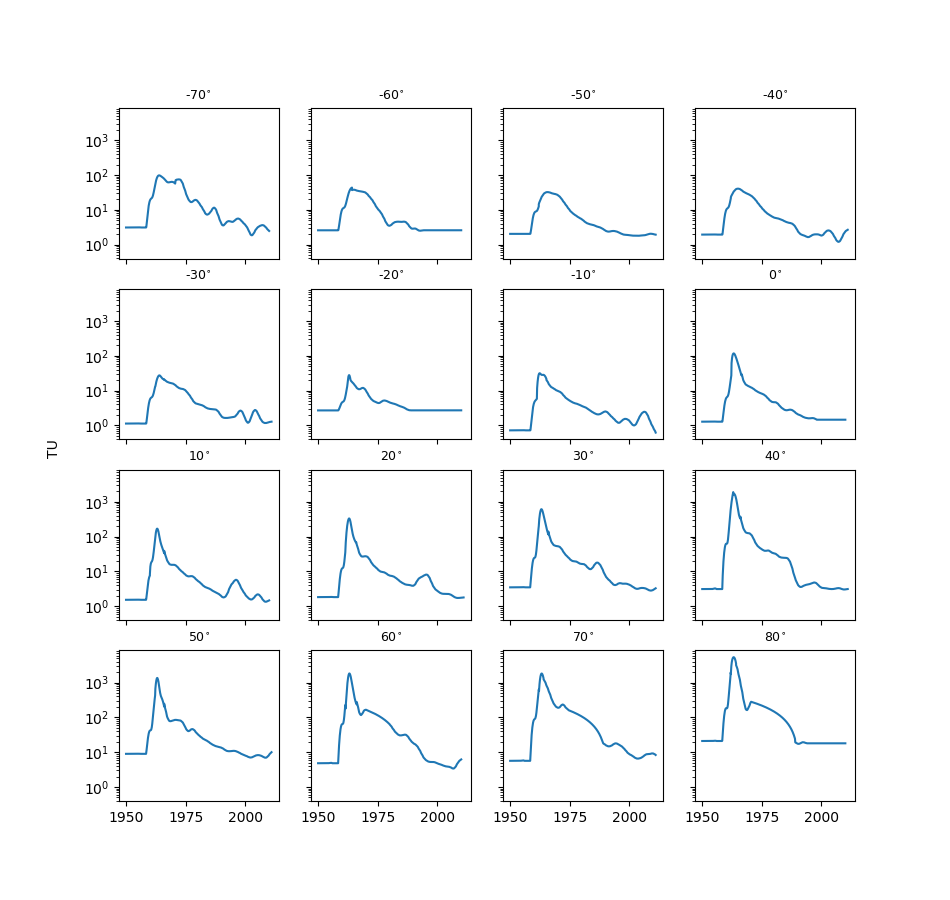

In [3]:
fig, axs = plt.subplots(nrows=4,ncols=4,sharex=True,sharey=True,figsize=(9.5,9))
for ax, k, lat in zip(axs.ravel(),skeys[np.argsort(nkeys)],nkeys[np.argsort(nkeys)]):
    year, flux = pkl[k]['fit']
    _ = ax.semilogy(year,flux,'-')
    _ = ax.set_title(r'%d$^{\circ}$'%lat,fontsize=9)
_ = fig.text(0.05,0.5,'TU',rotation=90)

## Create 2-D (lat, time) surface using blended fits

### Create data array with lat, time & flux from blended fits

In [4]:
case = 'fit'
sinds = np.argsort(nkeys)
dlist = []
for k, l in zip(skeys[sinds],nkeys[sinds]):
    x = np.c_[pkl[k][case][0],np.repeat(l+5,pkl[k][case][0].shape),pkl[k][case][1]]
    dlist.append(x)

data = np.concatenate(dlist,0)

### Interpolate blended fits to regular 2-D surface

In [5]:
time_grd, lat_grd = np.meshgrid(np.arange(1950,2011.1,0.2),np.arange(-65,86)) # 2-D surface coordinates

# time_monthly = np.r_[1950,1950 + np.tile(dpm,61).cumsum()/365] # monthly intervals
# time_grd, lat_grd = np.meshgrid(time_monthly,np.arange(-70,90,10)) # 2-D surface coordinates

coords, vals = data[:,:2], np.log(data[:,2])
z_linear = griddata(coords,vals,(time_grd,lat_grd),method='linear') # linear fit of log transformed data
z_linear = np.exp(z_linear)
z_linear = np.ma.masked_where(np.isnan(z_linear),z_linear)

z_cubic  = griddata(coords,vals,(time_grd,lat_grd),method='cubic')  # cubic spline of log transformed data
z_cubic = np.exp(z_cubic)
z_cubic  = np.ma.masked_where(np.isnan(z_cubic),z_cubic)

x, y, z = data[:,0], data[:,1], np.log(data[:,2]) # smooth spline of log transformed data
tck = bisplrep(x,y,z)
z_spline = bisplev(time_grd[0,:],lat_grd[:,0],tck)
z_spline = np.exp(z_spline).transpose()

#### Plot 2-D surfaces

<IPython.core.display.Javascript object>


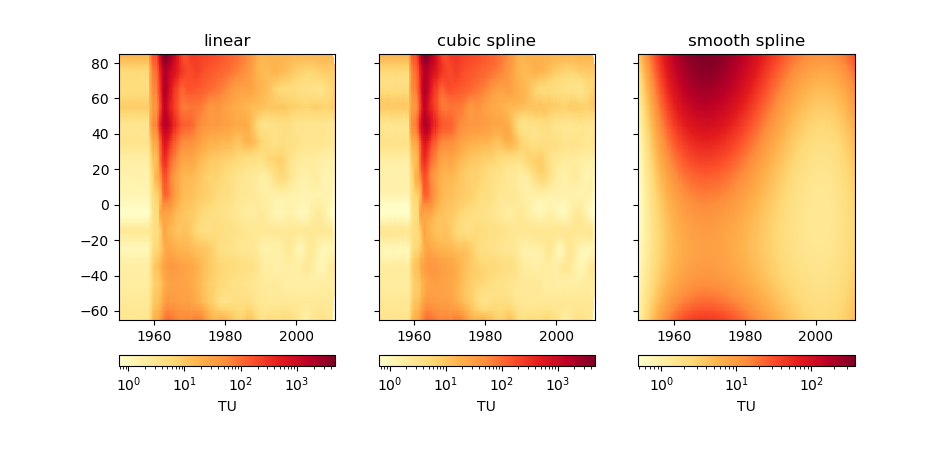

In [6]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(9.5,4.6))
for ax, z, title in zip(axs.ravel(),[z_linear,z_cubic,z_spline],['linear','cubic spline','smooth spline']):
    pm = ax.pcolormesh(time_grd,lat_grd,z,norm=colors.LogNorm(),cmap=plt.cm.YlOrRd)
    _ = ax.set_title(title)
    cb = fig.colorbar(pm,ax=ax,orientation='horizontal',pad=0.1)
    cb.set_label('TU')

<IPython.core.display.Javascript object>


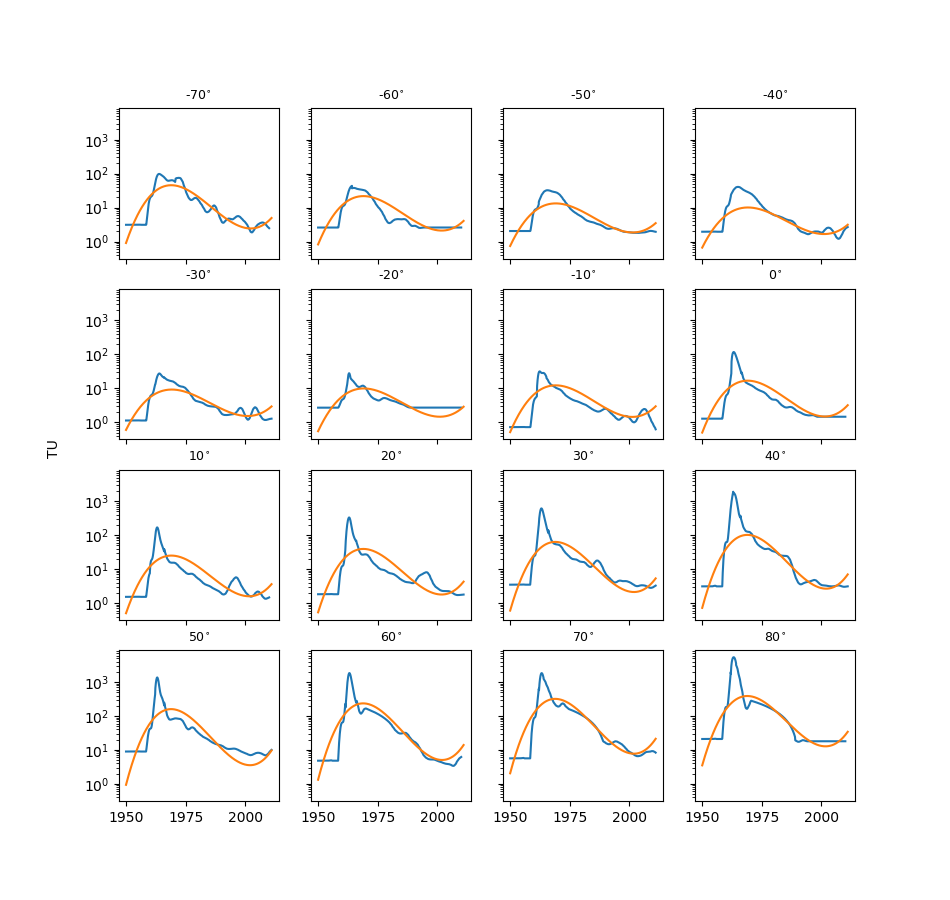

In [7]:
fig, axs = plt.subplots(nrows=4,ncols=4,sharex=True,sharey=True,figsize=(9.5,9))
for ax, k, lat, z in zip(axs.ravel(),skeys[np.argsort(nkeys)],nkeys[np.argsort(nkeys)],z_spline[::10,:]):
    year, flux = pkl[k]['fit']
    _ = ax.semilogy(year,flux,'-')
    _ = ax.semilogy(time_grd[0,:],z,'-')    
    _ = ax.set_title(r'%d$^{\circ}$'%lat,fontsize=9)
_ = fig.text(0.05,0.5,'TU',rotation=90)

<IPython.core.display.Javascript object>


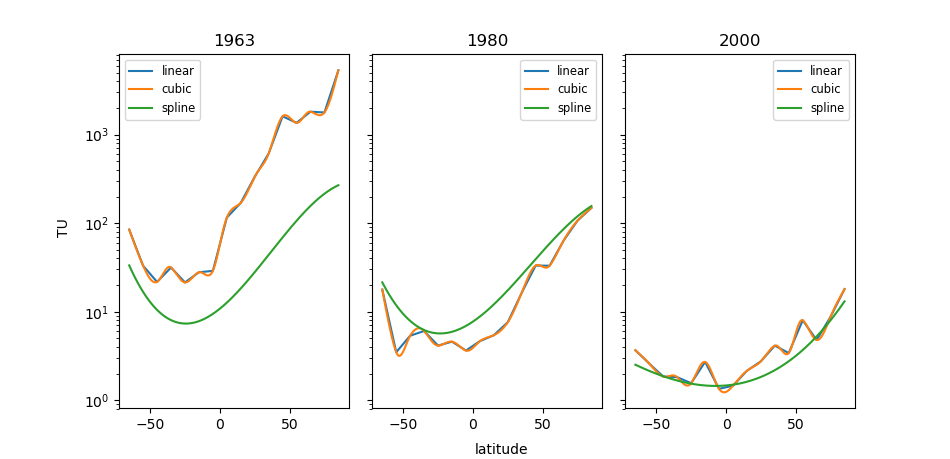

In [8]:
yrs = [1963,1980,2000]
inds = np.searchsorted(time_grd[0,:],yrs)
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(9.5,4.6))
fig.subplots_adjust(wspace=0.1)
for ax, ii in zip(axs.ravel(),inds):
    x = lat_grd[:,ii]
    y_linear, y_cubic, y_spline = z_linear[:,ii], z_cubic[:,ii], z_spline[:,ii]
    _ = ax.semilogy(x,y_linear,'-',label='linear')
    _ = ax.semilogy(x,y_cubic,'-',label='cubic')
    _ = ax.semilogy(x,y_spline,'-',label='spline')
    _ = ax.legend(loc='best')
    _ = ax.set_title('%d'%time_grd[0,ii])
    
_ = fig.text(0.06,0.5,'TU',rotation=90)
_ = fig.text(0.5,0.01,'latitude')

## Interpolate blended fits to monthly intervals

In [9]:
# time_monthly = np.linspace(1950,2011,733)
time_monthly = np.r_[1950,1950 + np.tile(dpm,61).cumsum()/365] # monthly intervals
sinds = np.argsort(nkeys)
alist = []
for k in skeys[sinds]:
    yr, tr = pkl[k][case]
    alist.append(np.interp(time_monthly,yr,tr).reshape(1,-1))
    
data_monthly = np.concatenate(alist,0)
data_monthly = np.vstack((data_monthly[0,:],data_monthly))
lats = np.hstack(([-80],nkeys[sinds]))

In [10]:
# file = '/bali/data/ilima/cesm/archive/tr3he.GIAF.03/ocn/hist/tr3he.GIAF.03.pop.h.0186-12.nc'
# ds = xr.open_dataset(file, decode_times=False)
# ds.TLAT.diff(dim='nlat').min(), ds.TLAT.diff(dim='nlat').max()

## Smooth along latitude

In [11]:
lats2 = np.arange(-80,90)
data_monthly2 = np.zeros((lats2.shape[0], data_monthly.shape[1]))

# data_monthly2 = np.copy(data_monthly)
# def cspline(x,y,s=1):
#     tck = splrep(x, np.log(y), s=s)
#     ynew = splev(x, tck, der=0)
#     return np.exp(ynew)

def cspline(x,y,s=0):
    tck = splrep(x, np.log(y), s=s)
    ynew = splev(lats2, tck, der=0, ext=3)
    return np.exp(ynew)

for n in range(data_monthly.shape[-1]):
    # data_monthly2[:,n] = savgol_filter(data_monthly[:,n], 9, 4)
    data_monthly2[:,n] = cspline(lats,data_monthly[:,n])

### Plot fields

<IPython.core.display.Javascript object>


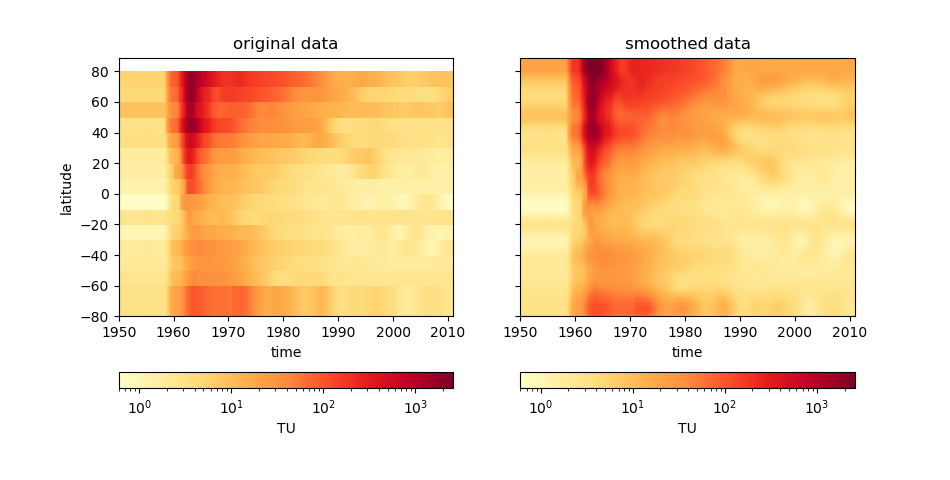

In [12]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9.5,4.8))
vmin, vmax = 0.6, 2600

pm = axs[0].pcolormesh(time_monthly,lats,data_monthly,norm=colors.LogNorm(),cmap=plt.cm.YlOrRd, vmin=vmin, vmax=vmax)
cb = fig.colorbar(pm,ax=axs[0], orientation='horizontal')
cb.set_label('TU')
_ = axs[0].set(xlabel='time', ylabel='latitude', title='original data')
#print(pm.get_clim())

pm = axs[1].pcolormesh(time_monthly,lats2,data_monthly2,norm=colors.LogNorm(),cmap=plt.cm.YlOrRd, vmin=vmin, vmax=vmax)
cb = fig.colorbar(pm,ax=axs[1], orientation='horizontal')
cb.set_label('TU')
_ = axs[1].set(xlabel='time', title='smoothed data')
#print(pm.get_clim())

fig.savefig('tritium_dep_ocn1.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


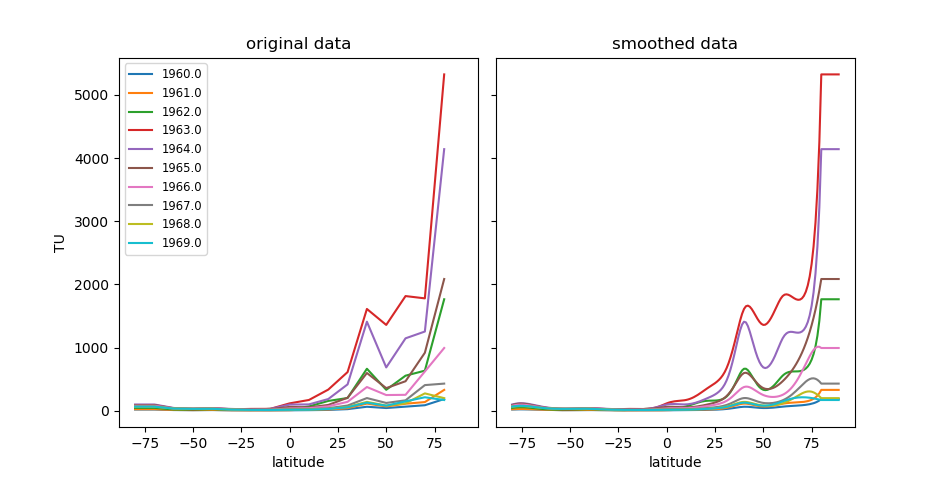

In [13]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9.5,4.8))
fig.subplots_adjust(wspace=0.05)
for n in range(120,240,12):
    _ = ax[0].plot(lats, data_monthly[:,n], label=time_monthly[n])
    _ = ax[1].plot(lats2, data_monthly2[:,n])
    
_ = ax[0].legend(loc='upper left')
_ = ax[0].set(ylabel='TU', xlabel='latitude', title='original data')
_ = ax[1].set(xlabel='latitude', title='smoothed data')

fig.savefig('tritium_dep_ocn2.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


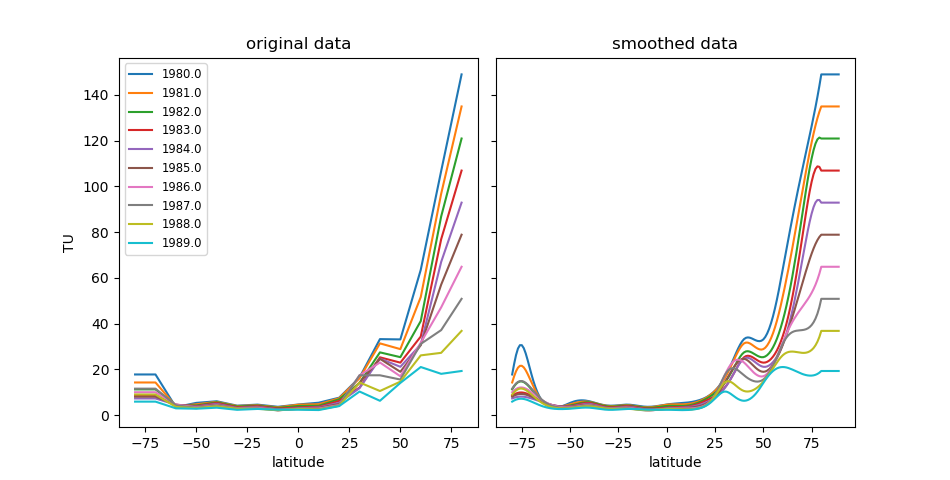

In [14]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(9.5,4.8))
fig.subplots_adjust(wspace=0.05)
for n in range(360,480,12):
    _ = ax[0].plot(lats, data_monthly[:,n], label=time_monthly[n])
    _ = ax[1].plot(lats2, data_monthly2[:,n])
    
_ = ax[0].legend(loc='upper left')
_ = ax[0].set(ylabel='TU', xlabel='latitude', title='original data')
_ = ax[1].set(xlabel='latitude', title='smoothed data')

### Write 2-D field to netCDF file

In [15]:
tritium = xr.DataArray(data_monthly2, name='tritium',
                       coords=[('lat_bins',lats2,{'long_name':'lower bound of latitude bin','units':'degrees north'}),
                               ('time',time_monthly,{'units':'common_years since 0000-01-01 00:00:00',
                                                     'calendar':'noleap'})],
                       attrs={'long_name':'tritium concentration','units':'tritium units'}) # create DataArray
ds = xr.Dataset({'tritium':tritium})  # create Dataset
ds.to_netcdf('tritium_dep_gnip_ocn.nc',format='NETCDF3_CLASSIC',
             encoding={'time':{'_FillValue':1.e+20},'tritium':{'_FillValue':1.e+20}}) # write Dataset to netCDF file

In [16]:
df = ds.to_dataframe().unstack(level=0)
df.to_csv('tritium_dep_gnip_ocn.txt',sep=' ',float_format='%.9f')

In [19]:
lats.shape, lats2.shape

((17,), (170,))